In [1]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import fbeta_score, make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay
from utils.data_loader import load_split, prepare_features_target
from utils.learning_curve import learning_curve_with_resampling
from models.manage_models import save_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
import optuna
import numpy as np
import matplotlib.pyplot as plt

In [2]:
f2_scorer = make_scorer(fbeta_score, beta=2)

In [3]:
train_df = load_split('train', data_dir='dataset/splits')
X_train, y_train = prepare_features_target(train_df, target_col='Fault')

In [4]:
def objective(trial):
    sampling_strategy = trial.suggest_categorical("sampling", ["none", "under"])

    kernel = trial.suggest_categorical('kernel', ['rbf', 'sigmoid']) 
    C = trial.suggest_float('C', 1e-2, 1e2, log=True) 
    
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    steps = [('scaler', StandardScaler())]

    if sampling_strategy == "under":
        steps.append(('resample', RandomUnderSampler(random_state=42)))

    model = SVC(
        kernel=kernel,
        C=C,
        gamma=gamma,
        class_weight='balanced', 
        cache_size=2000, 
        tol=1e-3,       
        random_state=42
    )

    steps.append(('model', model))
    pipeline = ImbPipeline(steps)

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    scores = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=cv, scoring=f2_scorer)
    
    return scores.mean()

In [5]:
study = optuna.create_study(direction="maximize", study_name='svm_opt')
study.optimize(objective, n_trials=30, show_progress_bar=True) 

print(f"Mejor score (f2_scorer): {study.best_value}")
print(f"Mejores parámetros: {study.best_params}")

[I 2025-12-22 13:15:43,113] A new study created in memory with name: svm_opt


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-22 13:17:50,837] Trial 0 finished with value: 0.8687714818256752 and parameters: {'sampling': 'none', 'kernel': 'rbf', 'C': 69.84841896499474, 'gamma': 'auto'}. Best is trial 0 with value: 0.8687714818256752.
[I 2025-12-22 13:18:34,797] Trial 1 finished with value: 0.8576590732408196 and parameters: {'sampling': 'under', 'kernel': 'rbf', 'C': 11.700725288595471, 'gamma': 'scale'}. Best is trial 0 with value: 0.8687714818256752.
[I 2025-12-22 13:19:47,690] Trial 2 finished with value: 0.609491531274618 and parameters: {'sampling': 'none', 'kernel': 'sigmoid', 'C': 0.4278132126221895, 'gamma': 'scale'}. Best is trial 0 with value: 0.8687714818256752.
[I 2025-12-22 13:20:31,642] Trial 3 finished with value: 0.8524009363395318 and parameters: {'sampling': 'under', 'kernel': 'rbf', 'C': 6.5854009830757185, 'gamma': 'auto'}. Best is trial 0 with value: 0.8687714818256752.
[I 2025-12-22 13:21:49,452] Trial 4 finished with value: 0.6092492229429723 and parameters: {'sampling': 'none

In [6]:
df = study.trials_dataframe()

In [7]:
df.head()

,number,value,datetime_start,datetime_complete,duration,params_C,params_gamma,params_kernel,params_sampling,state
0,0,0.868771,2025-12-22 13:15:43.121627,2025-12-22 13:17:50.837517,0 days 00:02:07.715890,69.848419,auto,rbf,none,COMPLETE
1,1,0.857659,2025-12-22 13:17:50.840113,2025-12-22 13:18:34.796899,0 days 00:00:43.956786,11.700725,scale,rbf,under,COMPLETE
2,2,0.609492,2025-12-22 13:18:34.801569,2025-12-22 13:19:47.690452,0 days 00:01:12.888883,0.427813,scale,sigmoid,none,COMPLETE
3,3,0.852401,2025-12-22 13:19:47.694454,2025-12-22 13:20:31.642587,0 days 00:00:43.948133,6.585401,auto,rbf,under,COMPLETE
4,4,0.609249,2025-12-22 13:20:31.646265,2025-12-22 13:21:49.452076,0 days 00:01:17.805811,0.789155,scale,sigmoid,none,COMPLETE


In [8]:
optuna.visualization.plot_optimization_history(study)

In [9]:
optuna.visualization.plot_param_importances(study)

In [10]:
optuna.visualization.plot_contour(study, params=["kernel", "gamma"])

In [11]:
params = study.best_params.copy()
sampling = params.pop('sampling')

params

{'kernel': 'rbf', 'C': 69.84841896499474, 'gamma': 'auto'}

In [12]:
final_model = SVC(**params, 
                  random_state=42, 
                  class_weight='balanced', 
                  cache_size=2000, 
                  tol=1e-3)

In [13]:
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', final_model)
])

Folds CV:   0%|          | 0/5 [00:00<?, ?it/s]


Fold 1/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Train F2: 0.9237, Val F2: 0.8125
  Tamaño 14628 -> Train F2: 0.9062, Val F2: 0.8446
  Tamaño 22857 -> Train F2: 0.9030, Val F2: 0.8579
  Tamaño 31085 -> Train F2: 0.8975, Val F2: 0.8641
  Tamaño 39314 -> Train F2: 0.8961, Val F2: 0.8690
  Tamaño 47542 -> Train F2: 0.8946, Val F2: 0.8749
  Tamaño 55771 -> Train F2: 0.8939, Val F2: 0.8761


Folds CV:  20%|██        | 1/5 [08:37<34:29, 517.40s/it]

  Tamaño 64000 -> Train F2: 0.8924, Val F2: 0.8755

Fold 2/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Train F2: 0.9223, Val F2: 0.8063
  Tamaño 14628 -> Train F2: 0.9049, Val F2: 0.8401
  Tamaño 22857 -> Train F2: 0.9012, Val F2: 0.8503
  Tamaño 31085 -> Train F2: 0.8996, Val F2: 0.8594
  Tamaño 39314 -> Train F2: 0.8996, Val F2: 0.8656
  Tamaño 47542 -> Train F2: 0.8961, Val F2: 0.8675
  Tamaño 55771 -> Train F2: 0.8956, Val F2: 0.8709


Folds CV:  40%|████      | 2/5 [17:15<25:52, 517.60s/it]

  Tamaño 64000 -> Train F2: 0.8954, Val F2: 0.8730

Fold 3/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Train F2: 0.9323, Val F2: 0.8168
  Tamaño 14628 -> Train F2: 0.9133, Val F2: 0.8432
  Tamaño 22857 -> Train F2: 0.9068, Val F2: 0.8497
  Tamaño 31085 -> Train F2: 0.9031, Val F2: 0.8558
  Tamaño 39314 -> Train F2: 0.8992, Val F2: 0.8593
  Tamaño 47542 -> Train F2: 0.8967, Val F2: 0.8610
  Tamaño 55771 -> Train F2: 0.8956, Val F2: 0.8659


Folds CV:  60%|██████    | 3/5 [25:43<17:06, 513.33s/it]

  Tamaño 64000 -> Train F2: 0.8935, Val F2: 0.8682

Fold 4/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Train F2: 0.9195, Val F2: 0.7976
  Tamaño 14628 -> Train F2: 0.9076, Val F2: 0.8345
  Tamaño 22857 -> Train F2: 0.8984, Val F2: 0.8447
  Tamaño 31085 -> Train F2: 0.8995, Val F2: 0.8529
  Tamaño 39314 -> Train F2: 0.8971, Val F2: 0.8616
  Tamaño 47542 -> Train F2: 0.8958, Val F2: 0.8627
  Tamaño 55771 -> Train F2: 0.8951, Val F2: 0.8626


Folds CV:  80%|████████  | 4/5 [34:36<08:41, 521.28s/it]

  Tamaño 64000 -> Train F2: 0.8941, Val F2: 0.8663

Fold 5/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Train F2: 0.9134, Val F2: 0.8087
  Tamaño 14628 -> Train F2: 0.9032, Val F2: 0.8376
  Tamaño 22857 -> Train F2: 0.9003, Val F2: 0.8521
  Tamaño 31085 -> Train F2: 0.8999, Val F2: 0.8582
  Tamaño 39314 -> Train F2: 0.8973, Val F2: 0.8673
  Tamaño 47542 -> Train F2: 0.8959, Val F2: 0.8700
  Tamaño 55771 -> Train F2: 0.8951, Val F2: 0.8695


Folds CV: 100%|██████████| 5/5 [43:14<00:00, 518.88s/it]

  Tamaño 64000 -> Train F2: 0.8944, Val F2: 0.8721


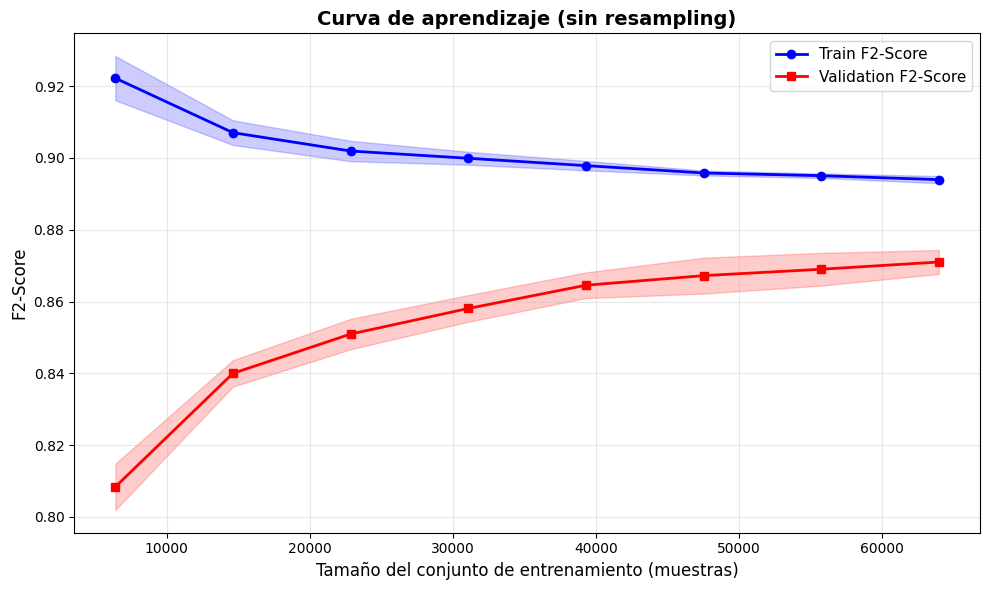


RESUMEN DE LA CURVA DE APRENDIZAJE
Mejor tamaño de entrenamiento: 64000 muestras
Mejor F2-Score en validación: 0.8710 (±0.0033)
F2-Score correspondiente en train: 0.8940


In [14]:
result = learning_curve_with_resampling(
    estimator=final_pipeline,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5,
    verbose=True,
    use_tqdm=True
)

In [15]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 SVC(C=69.84841896499474, cache_size=2000,
                     class_weight='balanced', gamma='auto', random_state=42))])

In [16]:
test_df = load_split('test', data_dir='dataset/splits')
X_test, y_test = prepare_features_target(test_df, target_col='Fault')

f2_scorer en test: 0.8737581585222511
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90     13800
         1.0       0.73      0.92      0.82      6200

    accuracy                           0.87     20000
   macro avg       0.85      0.89      0.86     20000
weighted avg       0.89      0.87      0.88     20000

Matriz de confusión:


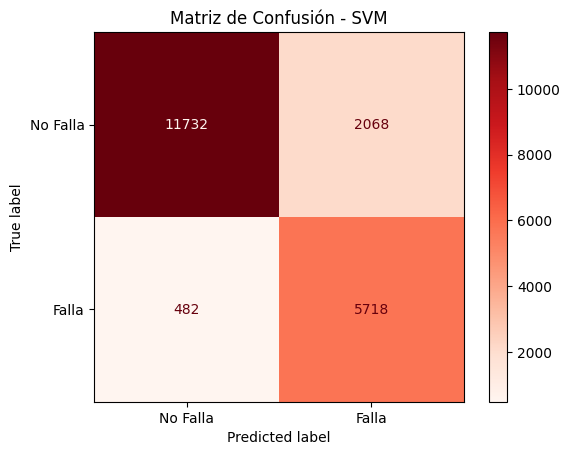

In [17]:
y_pred = final_pipeline.predict(X_test)

print("f2_scorer en test:",
      fbeta_score(y_test, y_pred, beta=2, average="macro"))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
# Plot it using the ConfusionMatrixDisplay imported
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=['No Falla', 'Falla'],
                             )
disp.plot(cmap='Reds')
plt.title('Matriz de Confusión - SVM')
plt.show()

In [18]:
paths = save_model(
    model=final_pipeline, 
    model_name='probl1_svm',
    save_path='models/',
    metadata={
        'augmented': False,
        'undersampled': False,
        'scaler_applied': True,
        'hyperparameters': final_pipeline.get_params()
    }
)

print(f"Modelo guardado en: {paths['model_path']}")

Modelo guardado en: models/probl1_svm_20251222_145735.joblib


creado
pipeline
fiteado
f2_scorer en test: 0.8737581585222511
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90     13800
         1.0       0.73      0.92      0.82      6200

    accuracy                           0.87     20000
   macro avg       0.85      0.89      0.86     20000
weighted avg       0.89      0.87      0.88     20000

Matriz de confusión:


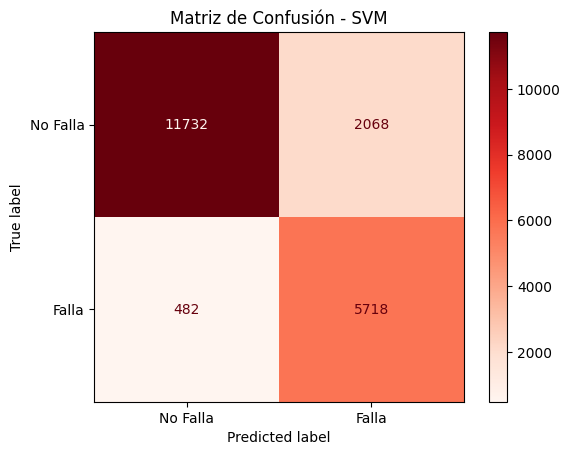

In [ ]:
# Esto me hizo falta para activar el proba de svm para poderlo mezclar con logistic regression {'kernel': 'rbf', 'C': 69.84841896499474, 'gamma': 'auto'}

final_model = SVC(kernel='rbf',
                  C=69.84841896499474,
                  gamma='auto',
                  random_state=42, 
                  class_weight='balanced', 
                  cache_size=2000, 
                  tol=1e-3,
                  probability=True)

print("creado")

final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', final_model)
])

print("pipeline")

final_pipeline.fit(X_train, y_train)

print("fiteado")

test_df = load_split('test', data_dir='dataset/splits')
X_test, y_test = prepare_features_target(test_df, target_col='Fault')

y_pred = final_pipeline.predict(X_test)

print("f2_scorer en test:",
      fbeta_score(y_test, y_pred, beta=2, average="macro"))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
# Plot it using the ConfusionMatrixDisplay imported
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=['No Falla', 'Falla'],
                             )
disp.plot(cmap='Reds')
plt.title('Matriz de Confusión - SVM')
plt.show()

In [20]:
paths = save_model(
    model=final_pipeline, 
    model_name='probl1_svm',
    save_path='models/',
    metadata={
        'augmented': False,
        'undersampled': False,
        'scaler_applied': True,
        'hyperparameters': final_pipeline.get_params()
    }
)

print(f"Modelo guardado en: {paths['model_path']}")

Modelo guardado en: models/probl1_svm_20251225_183323.joblib
